# Predict the Domgraphic of Products

In this project, we want to train a classifier to predict the target audience of a product, if the end consumer of a product is men, women, kids, baby or if it is unisex.
Our data include product information such as title, type, vendor name and product URL.

In the first step let's load our data.


## Load Data Set

In [1]:
import pandas as pd
inputFile = "../data/cleaned/outputFile2-0-1000000.csv"
df = pd.read_csv(inputFile, dtype={"primary_price": "string"})
df = df.drop(['id'], axis=1)
df = df[0:10000]
print("size=", df.shape)
display(df.head())

size= (10000, 8)


,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url
0,Cookware,Hestan,Hestan Nanobond Stainless 3qt/2.8L covered sau...,atlantagrillcompany.com,hestanculinary.com,NaN,290.0,https://atlantagrillcompany.com/products/hesta...
1,Cookware,Hestan,Hestan Nanobond Titanium Stockpot 8-Quart,atlantagrillcompany.com,hestanculinary.com,NaN,450.0,https://atlantagrillcompany.com/products/hesta...
2,Skillets,Hestan,"Hestan Nanobond 8.5"" Open Skillet",dasallas.com,hestanculinary.com,NaN,189.95,https://dasallas.com/products/hestan-nanobond-...
3,Saucepans & Sauciers,Hestan,Hestan Nanobond 5-Quart Covered Essential Pan ...,dasallas.com,hestanculinary.com,NaN,499.95,https://dasallas.com/products/hestan-nanobond-...
4,Cookware,Hestan,Hestan ProBond Forged Stainless Steel Ultimate...,atlantagrillcompany.com,hestanculinary.com,NaN,799.99,https://atlantagrillcompany.com/products/hesta...


## Preprocess Data

Now, let's define several helper methods for preprocessing our data.

In [2]:
# Lemmatize Normalization
def normalize(tokens):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(token, pos=get_wordnet_pos(token)) for token in tokens]

# map NLTK’s POS tags
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# tokenize, remove stop words and numbers
def standardize_text_v2(text):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    removals = digits + string.punctuation
    table = str.maketrans('', '', removals)
    words = [w.translate(table) for w in tokens]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    remove_list = [',', '(', ')', "'", '"', ' ', "'s", 'nan', "''", ',', '']
    words = [token for token in words if not token in remove_list]
    words = normalize(words)
    return words

# tokenize, lower, removes "http" , "https", "www"
def standardize_text_v3(text):
    removals = ["http", "https", "www", "/"]
    for item in removals:
        text = text.replace("item", "")
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    return tokens



Now, let's apply these methods to the columns we are interested. We do not want to remove stop words from Vendor name and website urls, hence we use standardize_text_v3 method and we use standardize_text_v2.

In [3]:
import nltk
import pandas as pd
import pickle
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from string import digits


df['title'] = df['title'].astype(str)
df['product_type'] = df['product_type'].astype(str)
df['description'] = df['description'].astype(str)
df['store_domain'] = df['store_domain'].astype(str)
df['vendor_name'] = df['vendor_name'].astype(str)
df['store_product_brand_domain'] = df['store_product_brand_domain'].astype(str)
df['vendor_name_original'] = df['vendor_name'].str.lower() #we need it later

df['product_type'] = df['product_type'].apply(standardize_text_v2)
df['vendor_name'] = df['vendor_name'].apply(standardize_text_v3)
df['store_domain'] = df['store_domain'].apply(standardize_text_v3)
df['description'] = df['description'].apply(standardize_text_v2)
df['title'] = df['title'].apply(standardize_text_v2)
df['store_product_brand_domain'] = df['store_product_brand_domain'].apply(standardize_text_v2)

# combine all token in all columns into one column
df['all_tokens'] = df.values[:, 0:6].sum(axis=1)
df['all_text'] = df['all_tokens'].apply(lambda x: " ".join(x))

## Applying Heuristics to Label our Unlabeled Data Set

Given that we no labelled records, we need to label some records. To achieve this, we have three options: 1-manually label some records, 2-prepare some heuristics to automate this job for us 3- use Amazon Sagemaker, Mechanical Turk or any other crowd sourcing websites 

In this tutorial, we prepare heuristics in python to label some records, so we can use them for training our classifiers.


### Labeling Phase 1

One simple heuristics which we can use is to count the exact keywords of our classes (baby, men, women, kid, unisex) or their synonyms in the product information, choose the label with the maximum count of occurrence.  So, in this step we define our classes and their synonyms and we look for their occurrence in our product information.


In [4]:
# our categories and their related words
classes = ['unisex', 'men', 'women', 'kid', 'baby']
manNet = ['man', 'men', 'male', 'gentleman', 'gent', 'masculine', ' manlike', ' mannish']
womanNet = ['woman', 'women', 'lady', 'female', 'ladies', 'girl', 'feminine']
babyNet = ['baby', 'toddler', 'infant', 'babe', 'bambino', 'infant', 'newborn']
kidNet = ['kid', 'child', 'children', 'child', 'youth', 'joni', 'schoolchild', 'schoolgirl', 'schoolkid', 'junior']
unisexNet = ['unisex', 'androgynous', 'genderless', 'unisexual']
all_Nets_list = [manNet, womanNet, babyNet, kidNet, unisexNet]


# count occurence of keywords in the list
def countFreq(product_info, keywordList):
    total_count = 0
    for item in product_info:
        total_count += keywordList.count(item)
    return total_count



In this step we count the occurrence of the keywords and select the label for each record according to the number occurrence of the keywords. For the records which we could not find any keyword, we set class to -1. So, class =-1 
returns us unlabeled records.

In [5]:
# which feature to focus for labeling
imp_feature = 'product_type'

df['unisex'] = df[imp_feature].apply(countFreq, keywordList=unisexNet)
df['men'] = df[imp_feature].apply(countFreq, keywordList=manNet)
df['women'] = df[imp_feature].apply(countFreq, keywordList=womanNet)
df['baby'] = df[imp_feature].apply(countFreq, keywordList=babyNet)
df['kid'] = df[imp_feature].apply(countFreq, keywordList=kidNet)
df['class'] = '-1'

In [6]:
# choose the label with the highest occurance of the keyword
def findLabel(row):
    maxCount = max(row)
    if maxCount > 0:
        maxLabel = row[row == maxCount].index[0]
    else:
        maxLabel = '-1'
    return maxLabel


# encode the classes to their index
df.loc[:, 'class'] = df.loc[:, classes].apply(findLabel, axis=1)

# keep track of record labeled in this round
labeled_data_index_r1 = df[df['class'] != '-1'].index.to_list()

print("Number of records labeled in round 1:", len(labeled_data_index_r1))
print("Number of records not labeled in round 1:", df.shape[0] - len(labeled_data_index_r1))

Number of records labeled in round 1: 138
Number of records not labeled in round 1: 9862


Let's see how the distribution of classes looks so far

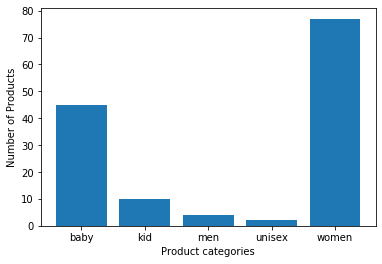

-1        9862
women       77
baby        45
kid         10
men          4
unisex       2
Name: class, dtype: int64


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(data_frame, groupby_feature, class_name, starting_index=0):
    grouped = data_frame.groupby([class_name])
    values = grouped[groupby_feature].agg(np.size)[starting_index:]
    labels = values.index.tolist()
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values)
    plt.xticks(y_pos, labels)
    plt.xlabel('Product categories')
    plt.ylabel('Number of Products')
    plt.show()
    print(data_frame[class_name].value_counts())
    
plot_class_distribution(df, 'product_type', 'class', starting_index=1)

### Labeling Phase 2

Now let's add another heuristic to label more records. In this step. we can look for common words and choose the ones which can uniquely identify a class and search for those keyword to label more record.

In this step, we assume that when an item is usually being used by one gender (for example, neckless is usually being worn by females), then a special type of neckless which is designed for men, will have men keyword in its description and has already being labelled in the previous round.

In [8]:


unisexProduct =['electronics','phone','fruit','movie','vegetable','seafood','ipad','video','music','book',
                'dairy','egg','fridge', 'phone','supplement','cable','cookware','cook','novel','bike','headphone',
                'appliance','battery','vitamin','fence','garden','speaker','camera','kitchen','radio','backpack',
                'frozen','food','household','safety','sex toys','skate','tuna','home']

womanProduct = ['jewellery','pregnancy','make up','nail polish','eye shadow','skirt','manicure','pedicure',
                'jewellery','bracelet','necklace','earring','jewelry','lingerie']

menProduct = ['shave', 'tuxedo']

kidProduct = ['school', 'disney', 'spider', 'barbie', 'doll']

babyProduct =  ['pacifier','stroller','diaper','potty','walker','playmat','car seat','lip liner','babyliss',
                 'maternity','teether','nursery','carrier','crib','rattle','sleeper']


Now let's count the new keyword in the product information.

Number of records labeled in round 2: 50
Number of records not labeled yet: 9812


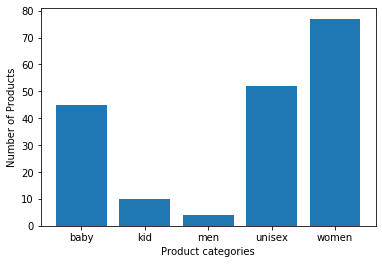

-1        9812
women       77
unisex      52
baby        45
kid         10
men          4
Name: class, dtype: int64


In [9]:

# find the total frequency of a list of keywords in a tokenized list
def count_occurance_keyword(tokenized_list, category_list):
    count = 0
    text_data = ' '.join(tokenized_list) + " "
    for keyword in category_list:
        count = text_data.count(keyword + " ")
    return count


def findLabel_commonKeywords(dataFrame, feature):
    count_unisex = count_occurance_keyword(dataFrame[feature], unisexProduct)
    count_men = count_occurance_keyword(dataFrame[feature], menProduct)
    count_woman = count_occurance_keyword(dataFrame[feature], womanProduct)
    count_kid = count_occurance_keyword(dataFrame[feature], kidProduct)
    count_baby = count_occurance_keyword(dataFrame[feature], babyProduct)

    index = ['unisex', 'men', 'women', 'kid', 'baby']
    counters = [count_unisex, count_men, count_woman, count_kid, count_baby]
    frequency = pd.Series(counters, index=index)

    # find label with maximum frequency
    max_frequency = max(frequency)
    max_label = frequency.idxmax() if max_frequency > 0 else '-1'
    return max_label


not_labled_index = df['class'] == '-1'
df.loc[not_labled_index, 'class'] = df.loc[not_labled_index, :].apply(findLabel_commonKeywords, axis=1,
                                                                      args=[imp_feature])

# Find records labeled in  round 2
# keep trackes of record labeled in this round
labeled_data_index = df[df['class'] != '-1'].index.to_list()

labeled_data_index_r2 = [i for i in labeled_data_index if i not in labeled_data_index_r1]


print("Number of records labeled in round 2:", len(labeled_data_index_r2))
print("Number of records not labeled yet:", df.shape[0] - len(labeled_data_index))

plot_class_distribution(df, 'product_type', 'class', starting_index=1)

Let's find most commmon words in product information which are not included in the categories lists

In [10]:
all_categories_lists = [unisexProduct, menProduct, womanProduct, kidProduct, babyProduct]
all_keyword_lists = all_Nets_list + all_categories_lists

all_keyword_set = set()
for list_a in all_keyword_lists:
    all_keyword_set.update(set(list_a))

# combine all rows' tokens  into one list
all_words = list([a for b in df['product_type'] for a in b])

# Find the most frequent words which are not included  categories lists
from nltk.probability import FreqDist
fdist = FreqDist(all_words)
for word, number in fdist.most_common(50):
    if word not in all_keyword_set:
        print(word, end=', ')

top, manga, accessory, dress, handle, material, pad, gear, game, computercamera, comic, protective, computerheadphonesoverthehead, graphic, musicvideo, dock, tool, pouch, photodigital, anime, hitch, flashlight, english, binoculars, knee, 

None of these keyword can be used to uniquely recognize a category, so let's move.

### Labeling Phase 3
If products from a vendor all belong to one particular category (given that at least 10 products are listed, we can assign that category to other products from the same vendor.

Number of records labeled in round 3: 3025
Number of records not labeled yet: 6787


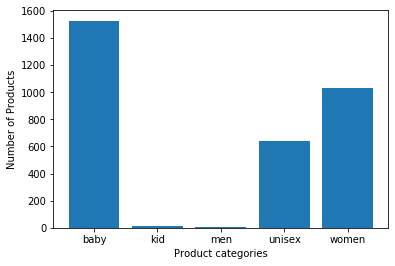

-1        6787
baby      1528
women     1031
unisex     640
kid         10
men          4
Name: class, dtype: int64


In [11]:

homo_brands = {}
labeled_data = df[df['class'] != '-1'].copy()
grouped = labeled_data.groupby(['vendor_name_original'])
for key, group in grouped:
    class_group = grouped.get_group(key).groupby(['class'])

    # if all products belong to one category
    if len(class_group) == 1:
        # If at least 10 products are listed for a company
        if (class_group['class'].count()[0]) > 10:
            homo_brands[key] = list(class_group.groups.keys())[0]


homo_vendor_bool = df['vendor_name_original'].apply(lambda x: x in list(homo_brands.keys()))
not_labled_bool = df['class'] == '-1'

# records which are not labeled yet and belong to homo vendor
homo_notLabeld_bool = np.logical_and(not_labled_bool, homo_vendor_bool)
homo_notLabeld_index = df[homo_notLabeld_bool].index

pd.DataFrame({'homo_vendor': homo_vendor_bool, 'not_labled_bool': not_labled_bool,
              'homo_notLabeld_bool': homo_notLabeld_bool})

def get_homo_class(x):
    vendor = x['vendor_name_original']
    return homo_brands[vendor]

df.loc[homo_notLabeld_index, 'class'] = df.loc[homo_notLabeld_index, :].apply(get_homo_class, axis=1)

# keep track of record labeled in round 3
labeled_data_index = df[df['class'] != '-1'].index.to_list()
labeled_data_index_before = labeled_data_index_r1 + labeled_data_index_r2
labeled_data_index_r3 = [i for i in labeled_data_index if i not in labeled_data_index_before]

print("Number of records labeled in round 3:", len(labeled_data_index_r3))
print("Number of records not labeled yet:", df.shape[0] - len(labeled_data_index))

plot_class_distribution(df, 'product_type', 'class', starting_index=1)

Now let's save the results, so we do not need to repeat labelling process every time!

In [12]:
dbfile = open('../data/labeled/labeled_dataV3', 'wb')
pickle.dump(df, dbfile)
dbfile.close()